In [244]:
import pandas as pd
import numpy as np
import os,json
import glob
import ntpath
import matplotlib.pyplot as plt
import zipfile
import pathlib
from IPython.display import Image
import missingno
import seaborn as sns
import logging
import boto3
from botocore.exceptions import ClientError
import configparser
import datetime
import logging
import s3fs
from datetime import date
from datetime import timedelta
logging.getLogger().setLevel(logging.CRITICAL)
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

## Goal : 

Due to the current crisis that Corona Virus spread over the world. Here the goal of this analysis is to find out demographic distribution and current status across nations

First part of the analysis will be in individual level in term of age, country and gender 

Second part will analysis from World Health Organization data in country level
    * Find out current trend
    * Calculating Recovered and Death rate
    
### Tools
1. Spark have used for data aggregation
2. AWS S3 have been used for file storage purpose and as Data Lake
3. Airflow will be used for data refresh scheduling

### Data Update Behaviour
1. Data will be refreshed in full rather than delta due to data source nature

### Step

Step 1 : Gather individual level information from varies datasets for some countries in Kaggle and consolidate them into DB schema (Section - Dataset Schema).
This schema has <u>individual patient</u> general information such as Age, Confirmed infected Date, Gender and Present location,etcs. You may find detail in section Dataset Schema.

(*Provide user flexibility whether to download updated data from Original datasource or Download it from S3)

Step 2: Aggregate step 1 resource and analysis demographic information

Step 3: Gather World Health Organisation (WHO) data in country level

Step 4: Calculating Ratios for analysis

Step 5: Gather additional data from Oxford - UK government for time series event

Step 6: Combin WHO data with step 5 and check whether those actions effectiveness



#### Source Link

novel-corona-virus-2019-dataset
https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

covid19-in-india
https://www.kaggle.com/sudalairajkumar/covid19-in-india

coronavirusdataset
https://www.kaggle.com/kimjihoo/coronavirusdataset

covid19-in-italy
https://www.kaggle.com/sudalairajkumar/covid19-in-italy

corona-virus-brazil
https://www.kaggle.com/unanimad/corona-virus-brazil

covid19-in-usa
https://www.kaggle.com/sudalairajkumar/covid19-in-usa

covid19-cases-switzerland
https://www.kaggle.com/daenuprobst/covid19-cases-switzerland

indonesia-coronavirus-cases
https://www.kaggle.com/ardisragen/indonesia-coronavirus-cases

Novel Corona Virus 2019 Dataset
https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/tasks

#### Upload  data to S3
<pre>
100x Usage preparation:
The goal of uploading data to S3 is to provide the service level flexiblity where if there is a 100x increase of users access this workbook, then we can upsizing the S3 capability
</pre>

In [245]:
def upload_file(file_name, bucket, object_name=None):
    s3_client = boto3.client('s3', aws_access_key_id=AWS_ACCESS_KEY,
                      aws_secret_access_key=AWS_SECRET_KEY)
    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [246]:
### AWS Configuration
config = configparser.ConfigParser()
config.read('aws.cfg')
os.environ['AWS_ACCESS_KEY_ID']=config["CREDENTIALS"]['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config["CREDENTIALS"]['AWS_SECRET_ACCESS_KEY']
AWS_ACCESS_KEY=config["CREDENTIALS"]['AWS_ACCESS_KEY_ID']
AWS_SECRET_KEY=config["CREDENTIALS"]['AWS_SECRET_ACCESS_KEY']

In [247]:
def readdata(filename):
    return pd.read_csv(filename, index_col=None)

In [248]:
#Load All Data
# download =1 meaning to download the latest data from Kaggle and upload it to S3
# download not equal to one, download data from S3
def loaddata(download):
    
    #download data from Kaggle and upload to S3
    
    filename =['coronavirusdataset','covid19-in-italy','corona-virus-brazil',
               'indonesia-coronavirus-cases',
              'covid19-in-usa','covid19-in-india',
               'novel-corona-virus-2019-dataset',
               'covid19-cases-switzerland'  ]
    
    country=['Korea','Italy','Brazil','Indonesia','USA','India','China','Switzerland']
    
    path = ['./data/Korea','./data/Italy','./data/Brazil',
        './data/Indonesia','./data/USA', './data/India','./data/China',
            './data/Switzerland' ]
    if download == 1 :
        os.system('kaggle datasets download --force  kimjihoo/coronavirusdataset')
        os.system('kaggle datasets download --force  kimjihoo/coronavirusdataset')
        os.system('kaggle datasets download --force  sudalairajkumar/covid19-in-italy')
        os.system('kaggle datasets download --force  unanimad/corona-virus-brazil')
        os.system('kaggle datasets download --force  daenuprobst/covid19-cases-switzerland')
        os.system('kaggle datasets download --force  ardisragen/indonesia-coronavirus-cases')
        os.system('kaggle datasets download --force  sudalairajkumar/covid19-in-usa')
        os.system('kaggle datasets download --force  sudalairajkumar/covid19-in-india')
        os.system('kaggle datasets download --force  sudalairajkumar/novel-corona-virus-2019-dataset')
        s3 = boto3.client('s3')
        
        for i in filename:
            with open(str(i)+'.zip', "rb") as f:
                s3.upload_fileobj(f, "demo-dataengineering",str(i)+'zip')
                file={}
    
    else :
        # Download from S3
        
        s4 = boto3.resource('s3')
        for i in filename:
            file =str(i)+'zip'
            s4.Bucket('demo-dataengineering').download_file(file, file)   
    
    path_to_zip_file=pathlib.Path().absolute()
    counter=0
    for i in filename:
        with zipfile.ZipFile(str(path_to_zip_file)+'/'+str(i)+'.zip', 'r') as zip_ref:
            zip_ref.extractall('./data/'+str(country[counter]))
        counter+=1
    z=0
    for i in path:
        all_files = glob.glob(i + "/*.csv")
        all_files = [w.replace(i, '') for w in all_files]
        all_files = [w.replace('.csv', '') for w in all_files]
        all_files = [w.replace('/', '') for w in all_files]
        for j in all_files:
            try:
                file['{}'.format(j)]  = readdata(str(i)+'/'+str(j)+'.csv') 
                file['{}'.format(j)]['Country']=country[z]       
            except:
     
                pass     
        z+=1
    return file

In [249]:
file= loaddata(1)

### Dataset Schema

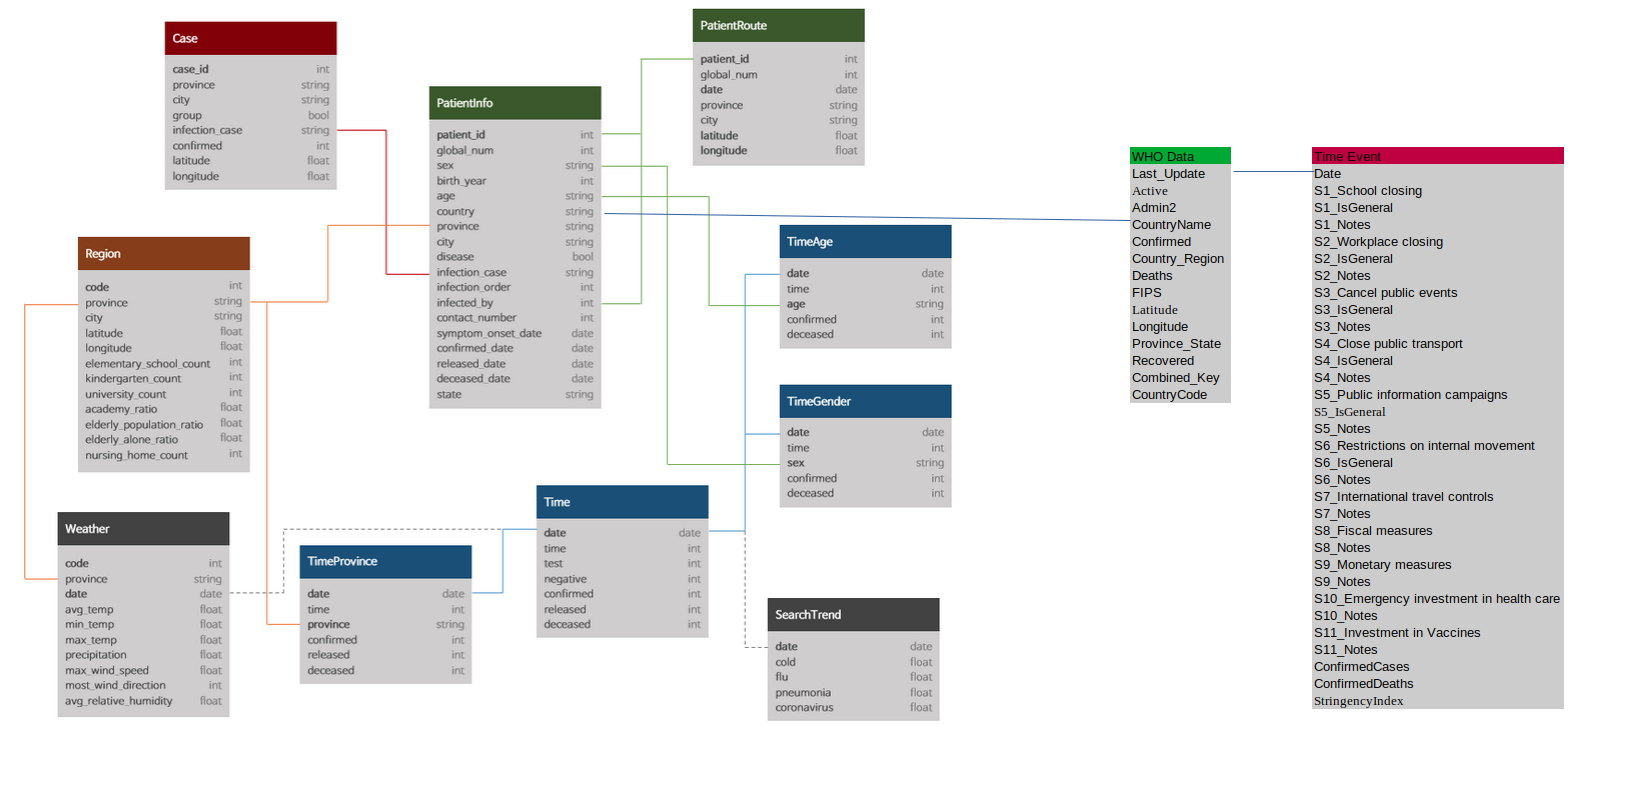

In [250]:
Image("DBSchema.png")

#### DB Schema description

This data model actually combine a lot of data sources and each has different database schema. The goal of this project is to centralise these information so. By above data schema , we can examine data in personal level in relate to weather, location (as it is not easier for every countries to provide every single person in database, therefore we need in broad level data from country level (WHOdata). Also in order to examine whether event effective to minimise the transmission rate, so that the time event table is needed

User query example :
User can query the no. of school in province geographically (Long and Lat) and check whether the elder has dropped in that area after school has closed


##### Left size around Patientinfo is Individual level 
<pre>
1) Case Data
    Case: Data of COVID-19 infection cases in South Korea
2) Patient Data
    PatientInfo: Epidemiological data of COVID-19 patients in South Korea
    PatientRoute: Route data of COVID-19 patients in South Korea
3) Time Series Data
    Time: Time series data of COVID-19 status in South Korea
    TimeAge: Time series data of COVID-19 status in terms of the age in South Korea
    TimeGender: Time series data of COVID-19 status in terms of gender in South Korea
    TimeProvince: Time series data of COVID-19 status in terms of the Province in South Korea
4) Additional Data
    Region: Location and statistical data of the regions in South Korea
    Weather: Data of the weather in the regions of South Korea
    SearchTrend: Trend data of the keywords searched in NAVER which is one of the largest portals in South Korea
</pre>
##### Right size data is from World Health Organization is on country level 
<pre>
<u><b2>WHO Data </b2></u>
<B>Fact Table </B>

It contains confirmed case, death, province per country geo location

Last_Update (Key) , Active , Admin2 , Combined_Key, Confirmed, Country_Region, Deaths, FIPS, Latitude, Longitude, Province_State, Recovered, CountryName, CountryCode

<u>Oxford COVID-19 Government Response Tracker</u>
<B>Dimension Table</B>

This table contain time series event, for example at 1-Mar-2020 Country A close all school then the S1_School closing is 1

Date (Key), S1_School closing, S1_IsGeneral, S1_Notes, S2_Workplace closing, S2_IsGeneral, S2_Notes, S3_Cancel public events, S3_IsGeneral, S3_Notes, S4_Close public transport, S4_IsGeneral, S4_Notes, S5_Public information campaigns, S5_IsGeneral, S5_Notes, S6_Restrictions on internal movement, S6_IsGeneral, S6_Notes
S7_International travel controls, S7_Notes, S8_Fiscal measures, S8_Notes, S9_Monetary measures, S9_Notes
S10_Emergency investment in health care, S10_Notes, S11_Investment in Vaccines, S11_Notes, ConfirmedCases
ConfirmedDeaths, StringencyIndex

</pre>

* No. of count have a wide range value meaning lots of missing data

In [251]:
file['PatientInfo'].describe()

,patient_id,global_num,birth_year,infection_order,infected_by,contact_number
count,3.128000e+03,1968.000000,2664.000000,31.000000,7.350000e+02,589.000000
mean,3.562811e+09,6234.729167,1974.456832,2.387097,2.557286e+09,18.908319
std,2.210168e+09,3297.461518,20.250896,1.453213,1.645931e+09,76.652155
min,1.000000e+09,1.000000,1916.000000,1.000000,1.000000e+09,0.000000
25%,1.300000e+09,3624.750000,1960.000000,1.000000,1.200000e+09,2.000000
50%,2.000001e+09,7437.500000,1974.000000,2.000000,2.000000e+09,4.000000
75%,6.001001e+09,9085.250000,1993.000000,3.000000,4.100000e+09,14.000000
max,7.000000e+09,10329.000000,2020.000000,6.000000,6.100000e+09,1160.000000


* Disease, sympton date, Release date and deceased date have a certain no. of missing value

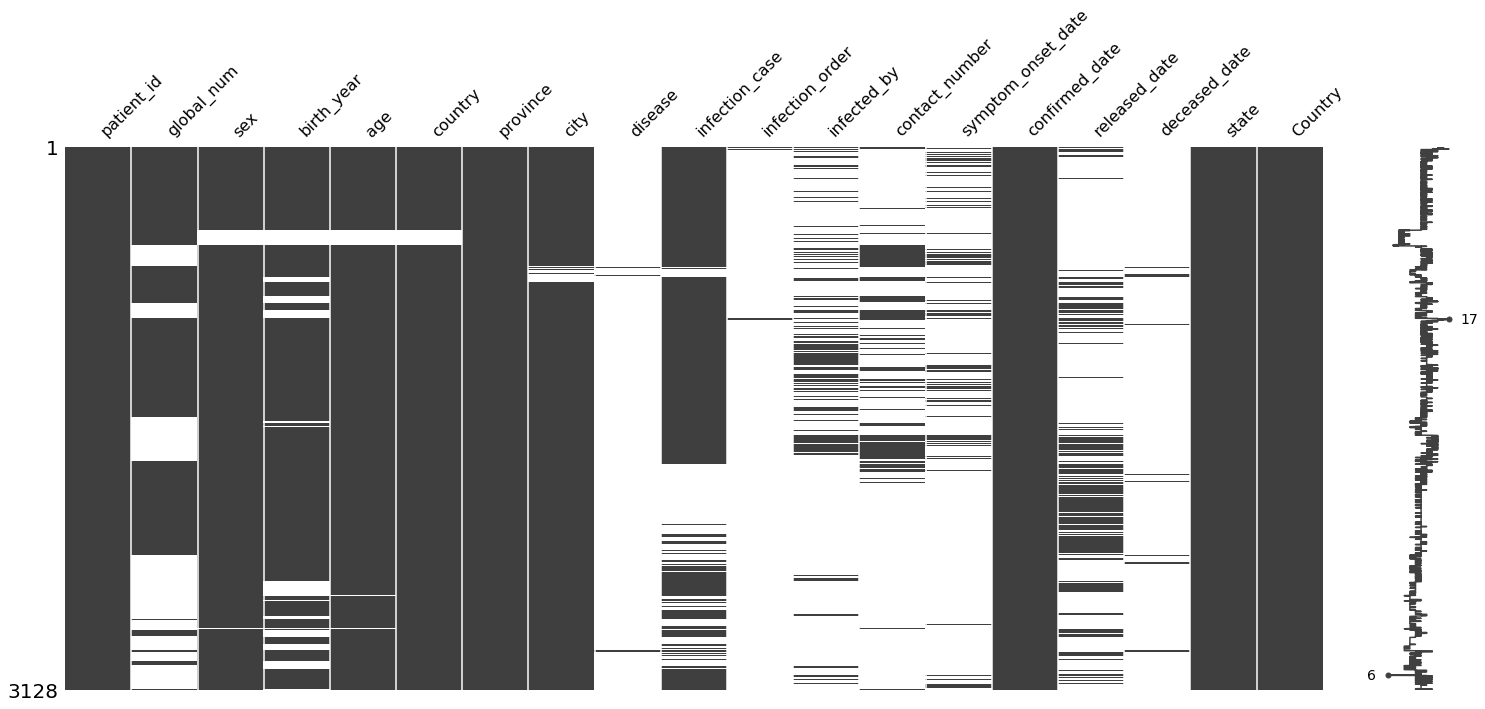

In [252]:
missingno.matrix(file['PatientInfo'])

In [253]:
file['PatientInfo']=file['PatientInfo'].fillna('na')

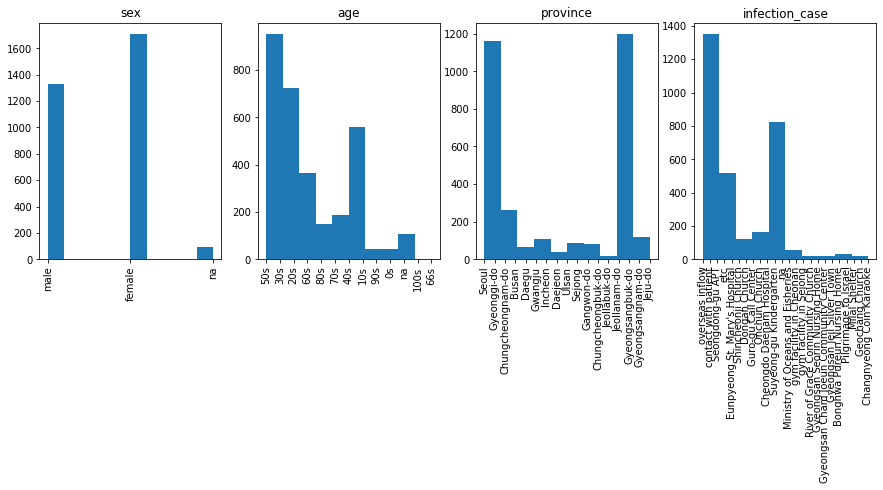

In [254]:
check = ['sex','age','province','infection_case']
     #   'symptom_onset_date','confirmed_date','released_date',
     #   'deceased_date'
plt.figure(figsize=(15, 20))
counter=1
for i in check:
    plt.subplot(4,4,counter)
    plt.hist(file['PatientInfo'][i])
    plt.xticks(rotation=90)
    plt.title(i)
    counter+=1
plt.show()

Consolidate different data source into the aforesaid schema - fact table in country level

### China data

In [255]:
temp = file['COVID19_open_line_list']
temp = temp[temp['country']=='China']
china = pd.DataFrame(temp)
china['patient_id'] = temp['ID']
china['global_num']='na'
china['sex']=temp['sex']
china['birth_year']='na'
china['age']=temp['age']
china['country']='China'
china['province']=temp['province']
china['city']=temp['city']
china['disease']=temp['chronic_disease_binary']
china['infection_case']='na'
china['infection_order']='na'
china['contact_number']='na'
china['symptom_onset_date']=temp['date_onset_symptoms']
china['confirmed_date']=temp['date_confirmation']
china['released_date']='na'
china['deceased_date']='na'
china['state']='na'
china['Country']=temp['Country']
china['travel_history_dates']=temp['travel_history_dates']
china['travel_history_location']=temp['travel_history_location']
china['current_state']= 'na'

In [256]:
file['PatientInfo']['disease'] = np.where(True,1,0)
file['PatientInfo']['travel_history_dates']='na'
file['PatientInfo']['travel_history_location']='na'
file['PatientInfo']['current_state']='na'

### Indonesia

In [257]:
temp = file['patient']
Indonesia = pd.DataFrame()
Indonesia['patient_id'] = temp['patient_id']
Indonesia['global_num']='na'
Indonesia['gender']=temp['gender']
Indonesia['birth_year']='na'
Indonesia['age']=temp['age']
Indonesia['country']='Indonesia'
Indonesia['province']=temp['province']
Indonesia['city']='na'
Indonesia['disease']='na'
Indonesia['birth_year']='na'
Indonesia['infection_case']='na'
Indonesia['infection_order']='na'
Indonesia['contact_number']='na'
Indonesia['symptom_onset_date']='na'
Indonesia['confirmed_date']=temp['confirmed_date']
Indonesia['released_date']=temp['released_date']
Indonesia['deceased_date']=temp['deceased_date']
Indonesia['state']='na'
Indonesia['Country']=temp['Country']
Indonesia['travel_history_dates']= 'na'
Indonesia['travel_history_location']= 'na'
Indonesia['current_state']= temp['current_state']

### India

In [258]:
temp = file['IndividualDetails']
India = pd.DataFrame()
India['patient_id'] = temp['id']
India['global_num']='na'
India['gender']=temp['gender']
India['birth_year']='na'
India['age']=temp['age']
India['country']='India'
India['province']=temp['detected_district']
India['city']='detected_city'
India['disease']='na'
India['birth_year']='na'
India['infection_case']='na'
India['infection_order']='na'
India['contact_number']='na'
India['symptom_onset_date']='na'
India['confirmed_date']=temp['diagnosed_date']
India['released_date']='na'
India['deceased_date']='na'
India['state']='na'
India['Country']=temp['Country']
India['travel_history_dates']= 'na'
India['travel_history_location']= 'na'
India['current_state']= temp['current_status']
India['age'] = India['age'].fillna('na')
India['age'] = np.where(India['age']=='28-35',30,India['age']) #.astype(float)

##### Concenate this countries data into one dataframe

In [259]:
data = pd.concat([china,Indonesia,India,pd.DataFrame(file['PatientInfo'])])

/home/kk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


#### Clear data


1. Generalise all Gender in lower case
2. Datasets record age differently, e.g. 22-76 (the range is so wide and not helpful for analyisis, so mark it unknown) 
3. Generalise date format

In [260]:
### Clean Data
data['sex'] = data['sex'].str.lower()

In [261]:
def checkagerange(age):
    agerange=['11-15','16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65'
             , '66-70', '71-75', '76-80', '81-85', '86-90', '91-95']
    result=[]
    for i in age:
        if i <=10 :
            result.append('0-10')
        elif i == 999 :
            result.append('Unknown')
        elif i >  95 :
            result.append('> 95')
        else :
            result.append(agerange[int(i/5)-2])
    return result

In [262]:
def checkagerange(age):
    agerange=['11-15','16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65'
             , '66-70', '71-75', '76-80', '81-85', '86-90', '91-95']
    result=[]
    for i in age:
        if i <=10 :
            result.append('0-10')
        elif i == 999 :
            result.append('Unknown')
        elif i >  95 :
            result.append('> 95 ' +str(i)) 
        else :
            result.append(agerange[int(i/5)-2])
    return result

In [263]:
#the range is not useful 22-76
data['age']=data['age'].fillna('na')
data['age']= np.where( data['age'].str.find('-')!=-1 , 'na', data['age'])
data['age']= np.where( data['age'].str.find('-')>=0 , 'na', data['age'])
data['age']= np.where( data['age'].str.find('s')>=0 , data['age'].str.replace('s','') , data['age'])
data['age']= np.where( data['age']=='na', '999' , data['age'])
data['age']= data['age'].astype(str).astype(float)
data['age']= np.round(data['age'],decimals=0)
agerange= checkagerange(data['age'])
data['age_range']=agerange

In [264]:
def convertdate(date) : 
    result=[]
    for i in date:
        if str(i).find('.') != -1 :
            result.append(datetime.date(int(i[6:]), int(i[3:5]),int(i[0:2])))
        elif  str(i).find('-') == 4 :
            result.append(datetime.date(int(i[0:4]), int(i[5:7]),int(i[8:10])))
        elif  str(i).find('-') == 2 :
            month = datetime.datetime.strptime(i[3:6], "%b").month
            result.append(datetime.date(int(str(20)+str(i[7:10])),month,int(i[0:2])))
        elif  str(i).find('-') == 2 :
            month = datetime.datetime.strptime(i[3:6], "%b").month
        elif  str(i).find('-') == 1 :
            month = datetime.datetime.strptime(i[2:5], "%b").month
            result.append(datetime.date(int('20'+str(i[6:])),int(month),int(i[0:1])))
        elif (len(str(i))==8):
            print(i)
            result.append(datetime.date(int(str(i[0:3])),int(str(i[4:6])),int(i[6:8])))
        else :
            result.append(datetime.date(1990,1,1))
    return result

In [265]:
data['confirmed_date'] =  pd.to_datetime(convertdate(data['confirmed_date']))
data['deceased_date'] =  pd.to_datetime(convertdate(data['deceased_date']))

## Patient Demograhpic Distribution

* This section will check the age and gender distribution

#### - Age Distribution


* The Age range of confirmed case in Korea from <b>21 to 55</b> is high than <b>above 55</b> 
    - which may different from general perception that young people has stronger immune system than elders or
    - due to Social life ?

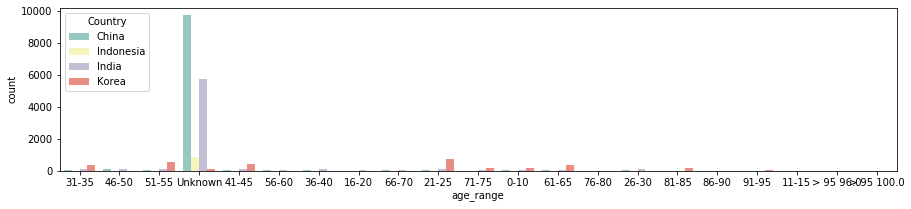

In [266]:
fig, ax = plt.subplots(figsize=(15,3))
sns.countplot(data=data ,x='age_range',hue='Country',palette="Set3",orient='h');

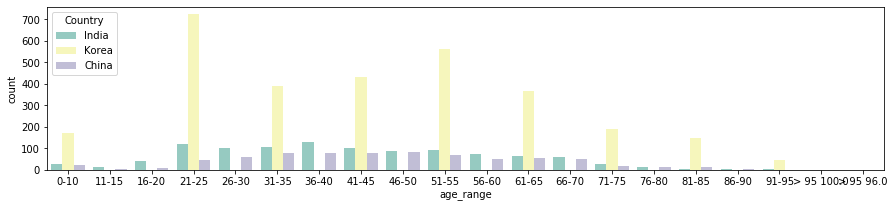

In [267]:
fig, ax = plt.subplots(figsize=(15,3))
sns.countplot(data=data[data['age_range']!='Unknown'].sort_values(['age_range']).reset_index(drop=True) ,x='age_range',hue='Country',palette="Set3",orient='h');

#### - Gender Distribution

* The female seems slightly higher than male for confirmed cases across different age range

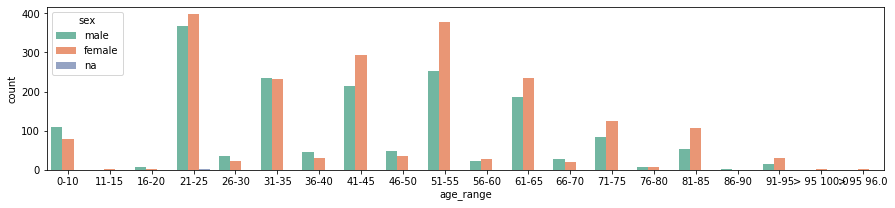

In [268]:
fig, ax = plt.subplots(figsize=(15,3))
sns.countplot(data=data[data['age_range']!='Unknown'].sort_values(['age_range']).reset_index(drop=True) ,x='age_range',hue='sex',palette="Set2",orient='h');

#### - Confirm Case  Trend in these countries

* China has dropped confirmed case slightly since middle of Feb

In [269]:
temp = data[data['confirmed_date']!='1990-01-01T00:00:00.000000000']
temp = temp[['confirmed_date','Country','ID']].groupby(['confirmed_date','Country']).agg('count').reset_index()

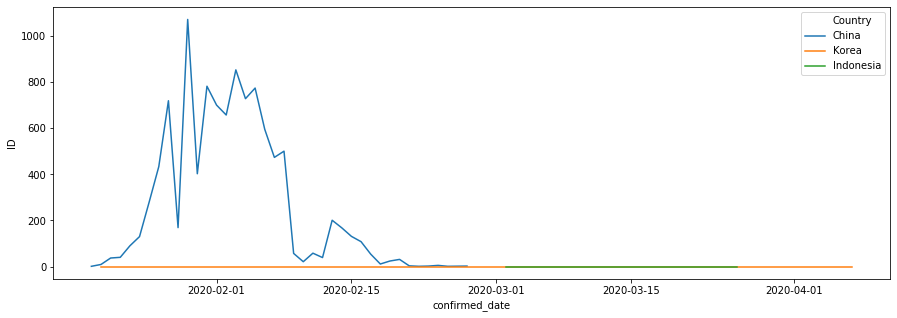

In [270]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x="confirmed_date", y="ID", data=temp,hue='Country')

### Data from World Health Organization and UK Government
This section checks data in country level (with no indivdual detail information)

* Check the confirmed case trend in each countries
* Calculate the recovered rate
* Calculate the death rate

Data structure :

Province/State: China - province name; US/Canada/Australia/ - city name, state/province name; Others - name of the event (e.g., "Diamond Princess" cruise ship); other countries - blank.
    
Country/Region: country/region name conforming to WHO (will be updated).
   
Last Update: MM/DD/YYYY HH:mm (24 hour format, in UTC).
   
Confirmed: the number of confirmed cases. For Hubei Province: from Feb 13 (GMT +8), we report both clinically diagnosed and lab-confirmed cases. For lab-confirmed cases only (Before Feb 17), please refer to who_covid_19_situation_reports. For Italy, diagnosis standard might be changed since Feb 27 to "slow the growth of new case numbers." (Source)
   
Deaths: the number of deaths.
   
Recovered: the number of recovered cases.


<u>WHO Data </u>
<B>Fact Table </B>

Last_Update (Key)
Active
Admin2
Combined_Key
Confirmed
Country_Region
Deaths
FIPS
Latitude
Longitude
Province_State
Recovered
CountryName
CountryCode

<u>Oxford COVID-19 Government Response Tracker</u>
<B> Dimension Table</B>
Date (Key)
S1_School closing
S1_IsGeneral
S1_Notes
S2_Workplace closing
S2_IsGeneral
S2_Notes
S3_Cancel public events
S3_IsGeneral
S3_Notes
S4_Close public transport
S4_IsGeneral
S4_Notes
S5_Public information campaigns
S5_IsGeneral
S5_Notes
S6_Restrictions on internal movement
S6_IsGeneral
S6_Notes
S7_International travel controls
S7_Notes
S8_Fiscal measures
S8_Notes
S9_Monetary measures
S9_Notes
S10_Emergency investment in health care
S10_Notes
S11_Investment in Vaccines
S11_Notes
ConfirmedCases
ConfirmedDeaths
StringencyIndex

In [271]:
def loadwhodata(download):
    if download==1 :
        begindate = datetime.date(2020,1,22)
        today = date.today()
        #01-22-2020.csv
        whodata=pd.DataFrame()
        day_count = (today - begindate).days + 1
        url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
        for single_date in (begindate + timedelta(n) for n in range(day_count)):
            try:
                filename = (str('{:02d}'.format(single_date.month))+'-'+str(single_date.day)+'-'+str(single_date.year))
                file = pd.read_csv(url+filename+'.csv')

                whodata = pd.concat([whodata,file])

            except Exception as e:
                pass
        whodata.to_csv('whodata.csv',index=False)
        s3 = boto3.client('s3')
        with open('./whodata.csv', "rb") as f:
            s3.upload_fileobj(f, "demo-dataengineering",'whodata.csv')
    else :
        whodata=pd.read_csv('whodata.csv')
        
    return whodata

In [272]:
whodata = loadwhodata(1)

/home/kk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


* Aggreate data for time series plot

In [273]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

In [274]:
# Clean data

whodata['Last_Update'] = np.where(pd.isnull(whodata['Last_Update']) , whodata['Last Update'],whodata['Last_Update'])
whodata['Country_Region'] = np.where(pd.isnull(whodata['Country_Region']) , whodata['Country/Region'],whodata['Country_Region'])
whodata['Latitude'] = np.where(pd.isnull(whodata['Latitude']) , whodata['Lat'],whodata['Latitude'])
whodata['Longitude'] = np.where(pd.isnull(whodata['Longitude']) , whodata['Long_'],whodata['Longitude'])
whodata['Province_State'] = np.where(pd.isnull(whodata['Province_State']) , whodata['Province/State'],whodata['Province_State'])
whodata['Province_State'] = np.where(pd.isnull(whodata['Province_State']) , whodata['Province/State'],whodata['Province_State'])
whodata['Last_Update']= pd.to_datetime(whodata['Last_Update'])
whodata["Last_Update"] = [d.date() for d in whodata["Last_Update"]]
whodata = whodata.drop(['Last Update','Lat','Long_','Province/State','Country/Region'],axis=1)
whodata['Country_Region']  = np.where(whodata['Country_Region'] =='Mainland China','China',whodata['Country_Region'] ) 
whodata['Confirmed'] = whodata['Confirmed'].fillna(0)
whodata['Recovered'] = whodata['Recovered'].fillna(0)
whodata['Deaths'] = whodata['Deaths'].fillna(0)
whodata['FIPS'] = whodata['FIPS'].fillna(0)

In [275]:
whodata[['Province_State','Admin2','Combined_Key']]=whodata[['Province_State','Admin2',
    'Combined_Key']].astype(str)
sqlContest = SQLContext(spark)
spark_df = sqlContest.createDataFrame(whodata)

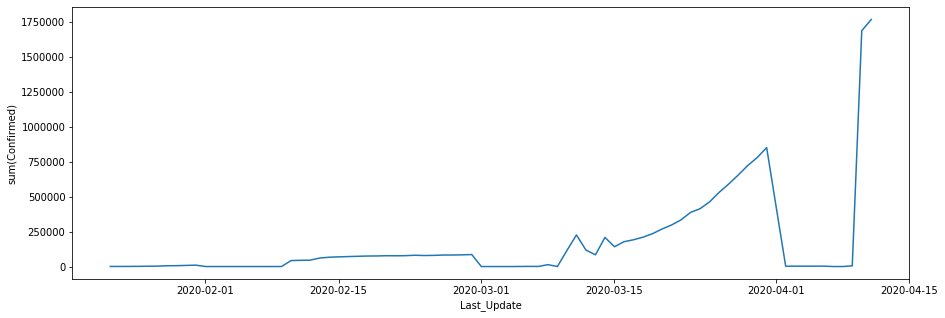

In [276]:
NoOfConfirmedByTime = spark_df.groupby('Last_Update').sum('Confirmed')
NoOfConfirmedByTime = NoOfConfirmedByTime.toPandas()
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x="Last_Update", y="sum(Confirmed)", data=NoOfConfirmedByTime)

* US has increased a lot confirmed case since mid of Mar

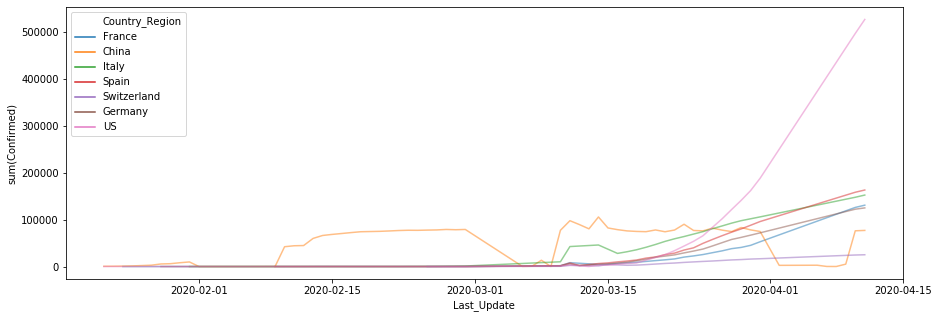

In [277]:
NoOfConfirmedByTime = spark_df.groupby(['Last_Update','Country_Region']).sum('Confirmed')
NoOfConfirmedByTime = NoOfConfirmedByTime.toPandas()

countrylist=['China','Spain','France','Italy','US','Germany','Switzerland']
NoOfConfirmedByTime = NoOfConfirmedByTime[NoOfConfirmedByTime['Country_Region'].isin(countrylist)]

fig, ax = plt.subplots(figsize=(15,5))
plt.legend(loc='lower left')
ax = sns.lineplot(x="Last_Update", y="sum(Confirmed)", data=NoOfConfirmedByTime,hue='Country_Region',alpha=0.5)

##### * Recover Rate is 30% after case confirmed and  Deaths Rate is 4.04% after case confirmed


In [278]:
import pyspark.sql.functions as F

Recovered = spark_df.groupby().sum('Recovered').alias('Recovered')
Confirmed = spark_df.groupby().sum('Confirmed').alias('Confirmed')
Deaths = spark_df.groupby().sum('Deaths').alias('Deaths')

In [279]:
spark_df.groupBy().agg(F.sum("Recovered")/F.sum("Confirmed")).show()

+---------------------------------+
|(sum(Recovered) / sum(Confirmed))|
+---------------------------------+
|              0.26108660079791757|
+---------------------------------+



In [280]:
spark_df.groupBy().agg(F.sum("Deaths")/F.sum("Confirmed")).show()

+------------------------------+
|(sum(Deaths) / sum(Confirmed))|
+------------------------------+
|          0.047111566618134135|
+------------------------------+



#### Extra features from Oxford about actions taken internationally provided by United Kingdom goverment in team of 
* is school close by date
* is work place closed
* Public event cancel
* Public transport
* International travel controls

This allow us to see if those actions has effectively reflect on confirmed cases

In [281]:
#www.bsg.ox.ac.uk
try:
    df=pd_read_excel(r'https://www.bsg.ox.ac.uk/sites/default/files/OxCGRT_Download_latest_data.xlsx')
except:
    df = pd.read_excel (r'OxCGRT_Download_latest_data.xlsx')

In [282]:
def getdiffvalue(lista,listb,unique=False):
    #print(lista)
    print(listb)
    result = np.setdiff1d(lista,listb,unique).tolist()
    if unique:
        return sorted(ans)
    return result

In [283]:
temp=df.copy()
temp = temp[temp['CountryName']=='China']

In [284]:
featureslist=['S1_School closing',
       'S2_Workplace closing','S3_Cancel public events','S4_Close public transport','S5_Public information campaigns',
       'S6_Restrictions on internal movement','S7_International travel controls','S8_Fiscal measures',
      'S9_Monetary measures','S10_Emergency investment in health care','S11_Investment in Vaccines'
     ]
featureslist = getdiffvalue(featureslist,df.columns.values.tolist())

['CountryName', 'CountryCode', 'Date', 'S1_School closing', 'S1_IsGeneral', 'S1_Notes', 'S2_Workplace closing', 'S2_IsGeneral', 'S2_Notes', 'S3_Cancel public events', 'S3_IsGeneral', 'S3_Notes', 'S4_Close public transport', 'S4_IsGeneral', 'S4_Notes', 'S5_Public information campaigns', 'S5_IsGeneral', 'S5_Notes', 'S6_Restrictions on internal movement', 'S6_IsGeneral', 'S6_Notes', 'S7_International travel controls', 'S7_Notes', 'S8_Fiscal measures', 'S8_Notes', 'S9_Monetary measures', 'S9_Notes', 'S10_Emergency investment in health care', 'S10_Notes', 'S11_Investment in Vaccines', 'S11_Notes', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex', 'Unnamed: 34']


* Clean Data
    - Generalise country name between two datasets
    
* Add additional features from other data source 

In [285]:
df['CountryName'] = np.where(df['CountryName']=='Macao' ,'Macao SAR', df['CountryName'] )
df['CountryName'] = np.where(df['CountryName']=='United States' ,'US', df['CountryName'] )
df['CountryName'] = np.where(df['CountryName']=='United States Virgin Islands' ,'US', df['CountryName'] )
df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

In [286]:
whodata['Last_Update']= pd.to_datetime(whodata['Last_Update'].astype(str), format='%Y-%m-%d')

In [287]:
whodata= pd.merge(whodata, df, left_on=['Last_Update', 'Country_Region'] , right_on =['Date','CountryName'])

In [288]:
whodata = whodata.sort_values(by=['CountryName','Country_Region','Last_Update'])

whodata['New Case']=np.where( (whodata['CountryName'] == (whodata['CountryName'].shift(1))) &
                         (whodata['Province_State'] == (whodata['Province_State'].shift(1))) ,
                         (whodata['Confirmed'].shift(1) - (whodata['Confirmed']))*-1 ,0 )

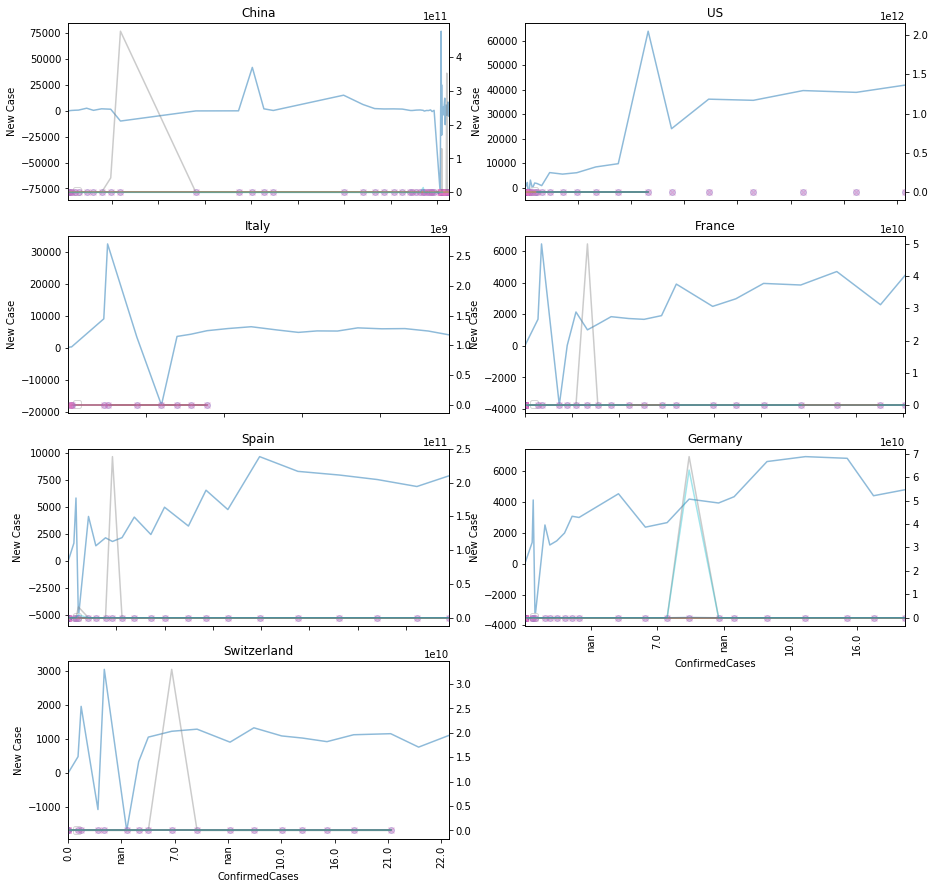

In [289]:
countrylist=['China','US','Italy','France','Spain','Germany','Switzerland']

temp = whodata.copy()
temp = temp.groupby(['CountryName','Last_Update']).agg({'Confirmed':'sum'})
temp= pd.merge(temp, df, left_on=['Last_Update', 'CountryName'] , right_on =['Date','CountryName'])
temp['New Case']=np.where( (temp['CountryName'] == (temp['CountryName'].shift(1))), 
                         (temp['Confirmed'].shift(1) - (temp['Confirmed']))*-1 ,0 )

plt.figure(figsize=(15, 15))
counter=1
for i in countrylist:
    temp2=temp[temp['CountryName']==i]
    plt.subplot(4,2,counter)
    plt.legend(loc='lower left')
    ax = sns.lineplot(x="ConfirmedCases", y="New Case", data=temp2,alpha=0.5)
    ax2 = ax.twinx()
    ax.set_title(i)
    temp2.plot(x="ConfirmedCases", y="S1_School closing", ax=ax2, legend=False, alpha=0.4)
    temp2.plot(x="ConfirmedCases", y="S2_Workplace closing", ax=ax2, legend=False, alpha=0.4)
    temp2.plot(x="ConfirmedCases", y="S3_Cancel public events", ax=ax2, legend=False, alpha=0.4)
    temp2.plot(x="ConfirmedCases", y="S4_Close public transport",ax=ax2, legend=False, alpha=0.4)
    temp2.plot(x="ConfirmedCases", y="S5_Public information campaigns", marker='o' ,ax=ax2, legend=False, alpha=0.4)
    temp2.plot(x="ConfirmedCases", y="S6_Restrictions on internal movement", ax=ax2, legend=False, alpha=0.4)
    temp2.plot(x="ConfirmedCases", y="S7_International travel controls", marker='x',ax=ax2, legend=False, alpha=0.4)
    temp2.plot(x="ConfirmedCases", y="S8_Fiscal measures", ax=ax2, legend=False,alpha=0.4)
    temp2.plot(x="ConfirmedCases", y="S9_Monetary measures", ax=ax2, legend=False,alpha=0.4)
    temp2.plot(x="ConfirmedCases", y="S10_Emergency investment in health care", ax=ax2, legend=False,alpha=0.4)
    temp2.plot(x="ConfirmedCases", y="S11_Investment in Vaccines", ax=ax2, legend=False,alpha=0.4)
    ax.set_title(i)
    ax.set_xticklabels(labels=temp['ConfirmedCases'], rotation=90)
    counter+=1
#ax.figure.legend(loc = 4)   
ax
plt.show()